## Intro

#### What's '/r/borrow'?
/r/borrow is a subreddit (an online forum hosted by the website 'Reddit') where people ask for and give informal loans. It's been in existence since fall 2014, after it's predeccessor, /r/loans,  decided to switch to a new forum name and implement a more straightforward set of rules. There is a pretty good article in The Atlantic about it ([here's a link](
https://www.theatlantic.com/business/archive/2016/05/reddit-borrow-peer-loan/481698/)), although it makes a few claims that I think are incorrect.

#### How does the loan process work on /r/borrow?
On /r/borrow, each loan is recorded publicly on the subreddit in two different places: a request post, and a 'paid'/'unpaid' post. First, the borrower asks for a loan and explains why they need it, how much they need, when they'll repay it, and how much interest they'll pay. (Note that the borrower tends to set the terms of the loan, although it's not uncommon to see "Happy to work out the interest rate with the lender" or something of that ilk.) After the request is posted, lenders contact the borrower via PM (private message), and the borrower chooses a lender. Money is exchanged through whatever channel they've chosen, and usually the lender collects personal information from the borrower. Commonly used channels include Venmo, Paypal, Zelle, and an app called "Cash." Common practice for collecting information from borrowers is to ask for a picture of the borrower holding up their drivers license and a note saying something like "I borrowed \[x\] amount from \[lender\]," and to get the borrower's social media profiles (e.g. Instagram, Facebook). If the loan is paid back on time, the lender then makes a 'paid' post, including the borrower's name and the size of the loan. If it's not paid back on time, the lender can make a 'late' post or an 'unpaid' post, detailing the situation. If an 'unpaid' post is made, the borrower is permanently blocked from the subreddit and added to a list of defaulted borrowers.

#### How did you get this data?
I initially wrote a program that used the Reddit API to download posts from the subreddit. However, I quickly discovered that Reddit had just changed its API rules to make it nearly impossible to download all posts on a subreddit. When I started looking for alternatives, I quickly discovered [pushshift.io](https://pushshift.io/), an awesome and immensely useful project. Pushshift is a full copy of Reddit's content, easily accessible through several different APIs. Many thanks to Pushshift for their excellent work!

#### What exactly did you do?
After downloading all posts on the subreddit, I wrote a program that extracted a few variables from the post titles. I processed 'paid' and 'unpaid' posts, since the main interesting outcome here is whether the loans were successful or not. Each post already has a date and author (in this case, the lender posts confirming repayment or failure to repay). However, the borrower's username and the size of the loan is written in semi-structured text in the title. That is, users type out the post titles, but there are rules that they're supposed to follow about what is in the title. Unfortunately, those rules are not rigorously enforced, and there are many typos and errors.

My parsing program extracted the borrower's name and the size of the loan from the title, and the author (lender) and date from the post metadata included in the JSON file that pushshift provides. The final data set spans 207 weeks and contains the lender name, borrower name, loan amount, repayment/default date, and a binary paid/defaulted variable for 16,336 loans.

After compiling the dataset, I created a network graph showing the entire subreddit history, and spent some time analzying the data to answer some questions I was interested in. The data, network graph, and my analyses are all available on Github.

(**Note:** I initially hoped to extract the interest rate/amount from this data as well, but the subreddit rules make it impossible to do so. Usually, the actual interest rate is determined via PM and is never publicly available. Often, borrowers will propose an interest rate, but the format is completely inconsistent, and there's no guarantee that the terms didn't change when the loan negotiation occurred via PM.)

#### A fun side-note:
Here's a link to the 'paid' post for the largest loan given on /r/borrow. Or rather, it was multiple 'loans' (e.g. this lender sent multiple chunks of money to this borrower), but this was the largest total outstanding loan amount for one lender/borrower pair at a single time.
https://www.reddit.com/r/borrow/comments/7crei7/paid_upepe_tapia_7055_across_multiple_loans/

## Setting up

In [1]:
# Load libraries and set plot parameters
import numpy as np
import pandas as pd
import seaborn as sns; sns.set()
from cycler import cycler
import json
import pytz
from scipy import stats

import datetime
datetime.datetime(1990, 1, 1, tzinfo=pytz.utc)

from matplotlib import cm
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'png')


In [2]:
# Functions
def readfile(fin):
    ''' Generic JSON reader, defaults to calling the file that getdata() outputs
    '''
    with open(fin) as f:
        vals = json.load(f)
    return vals

netdict = readfile("/Users/quinnbatten/Documents/Programming/PyProjects/rborrow/textfiles/new_netdict_out_outcomebool.json")
#netdict = readfile("/Users/quinnbatten/Documents/Programming/PyProjects/rborrow/textfiles/netdict_out_TEST.json")

# Fn to correctly format dollar amounts, thanks to: https://stackoverflow.com/questions/320929/currency-formatting-in-python#320951
converter = lambda amount: "%s%s%s"%(
    "-" if amount < 0 else "", 
    '$', 
    ('{:%d,.0f}'%(len(str(amount))+3)).format(abs(amount)).lstrip())

In [3]:
# Put into dataframe, do a bit of cleanup

def load_netdict(name):
    df_tmp = []
    for loan in name:
        tmp_loan = {'amt': '',
                    'bor': '',
                    'date': '',
                    'lend': '',
                    'paid': ''
                   }

        tmp_loan['amt'] = loan['amt']
        tmp_loan['bor'] = loan['bor']
        tmp_loan['lend'] = loan['lend']
        tmp_loan['date'] = loan['date']
        tmp_loan['date_h'] = datetime.datetime.utcfromtimestamp(loan['date']).strftime('%Y-%m-%d %H:%M:%S')
        tmp_loan['paid'] = loan['outcome']
        df_tmp.append(tmp_loan)
    return df_tmp


    
df = pd.DataFrame(load_netdict(netdict))
df.replace('NaN', np.nan, inplace=True)
df = df[df.amt != 0]
#df = df[~df.amt.isnull()]
df1 = df.copy()

In [4]:
# Setting a datetime index
df['date'] = pd.to_datetime(df['date_h'])
del df['date_h']
df.set_index('date', inplace=True)

In [5]:
# Do some cleaning
df[df.amt > 100000].index
df.at['2018-06-22 23:37:50','amt'] = 500
# https://www.reddit.com/r/borrow/comments/8t5uwz/paid_uchibiilala_300200int_on_time/

df[df.amt == 30050]
df.at['2018-07-27 22:23:35', 'amt'] = 350
# https://www.reddit.com/r/borrow/comments/92gzsj/paid_umagnitiki_30050int_on_time_w_ext/

df[df.amt == 20000]
df.at['2017-06-27 16:28:49', 'amt'] = 200
# https://www.reddit.com/r/borrow/comments/6jtu30/unpaid_umikethegrass_tupolo_ms_usa_20000_147_days/

df[df.amt == 12223] 
df.at['2015-05-15 18:41:32', 'amt'] = 600


(*Note:* After import, I had to do a bit of cleaning manually, mostly due to typos in post titles that resulted in incorrect loan amounts being read in.

At this initial cleaning stage, I also discovered that the parser was occasionally grabbing numbers from usernames and marking them as loan amounts. I made a change to the parser so that once it discovered a username, it cut the username out of the string before searching for a loan amount. None of that is shown in the code here, because it was a change in the python code that parses the file which this notebook then imports.)

In [6]:
# Set plot parameters for our plots
plt.style.use('bmh')

plt.rcParams['figure.figsize'] = 20, 15
plt.rcParams['axes.labelsize'] = 22
plt.rcParams['axes.titlesize'] = 30
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18
plt.rcParams['xtick.minor.visible'] = True
plt.rcParams['font.family'] = "serif"
plt.rcParams['font.serif'] = "Georgia"
plt.rcParams['figure.autolayout'] = False

## A quick visualization of all the loans that have moved through /r/borrow

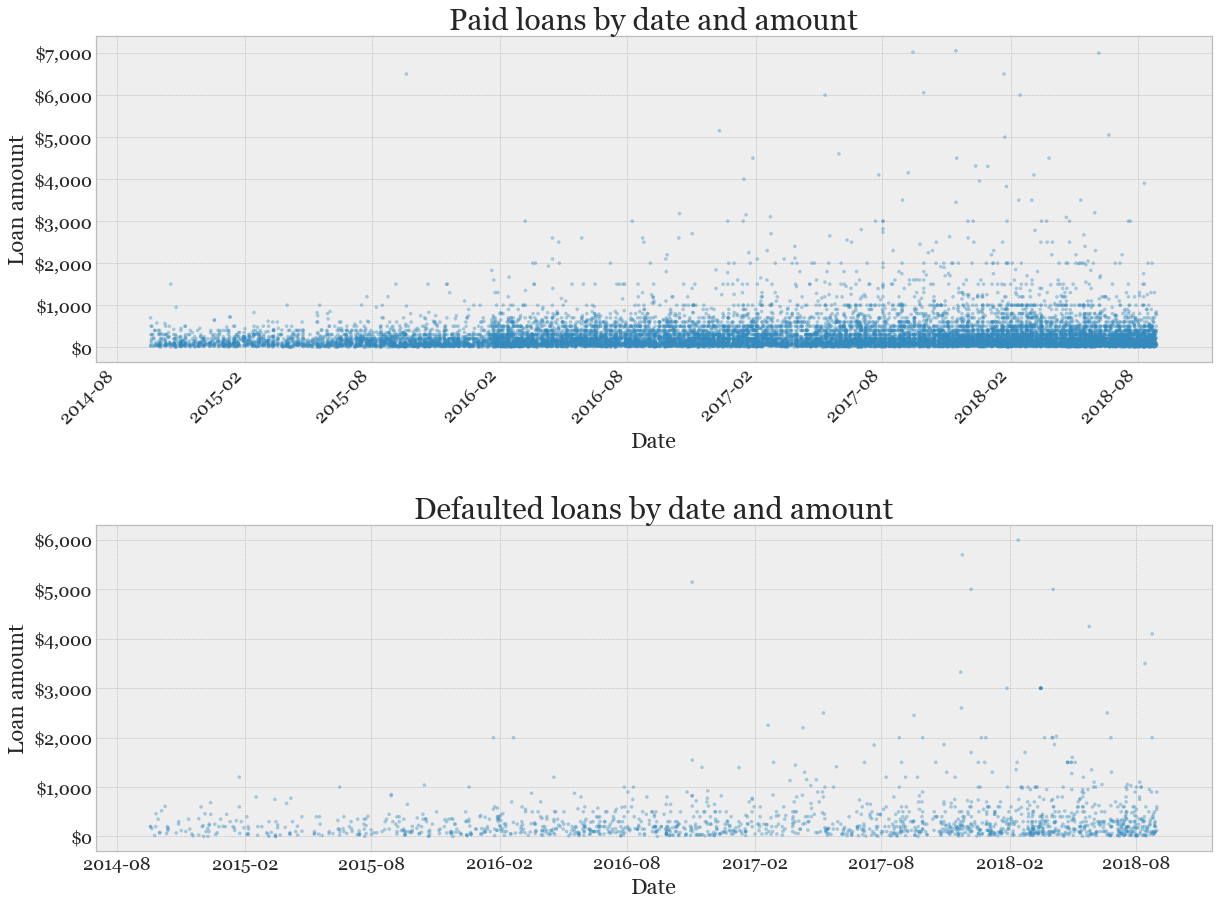

In [7]:
# Plot all loans by size and date
fig, (ax1, ax2) = plt.subplots(2, 1)
ax1.scatter(df[df.paid==1].index, df[df.paid==1].amt,s=13, alpha=0.4, edgecolor='none')
ax2.scatter(df[df.paid==0].index, df[df.paid==0].amt,s=13, alpha=0.4, edgecolor='none')
ax1.grid(True)
labels = ax1.get_xticklabels()
plt.setp(labels, rotation=45, horizontalalignment='right')
ax1.set(xlabel="Date", ylabel="Loan amount", title="Paid loans by date and amount")
ax1.get_yaxis().set_major_formatter(
    ticker.FuncFormatter(lambda x, p: converter(x)))
ax2.set(xlabel="Date", ylabel="Loan amount", title="Defaulted loans by date and amount")
ax2.get_yaxis().set_major_formatter(
    ticker.FuncFormatter(lambda x, p: converter(x)))
plt.subplots_adjust(hspace=0.5)

## Is it growing? How has the amount of activity on the forum changed over time?

First, let's graph the total amount repaid per week. 

In [8]:
# Making a new aggregated dataframe: sum of loans repaid each week
df_m = df[df.paid == 1].copy()
del df_m['bor']
del df_m['lend']
del df_m['paid']
df_m = df_m.resample('W').sum()
rolling = df_m.rolling(10, center=True).mean()

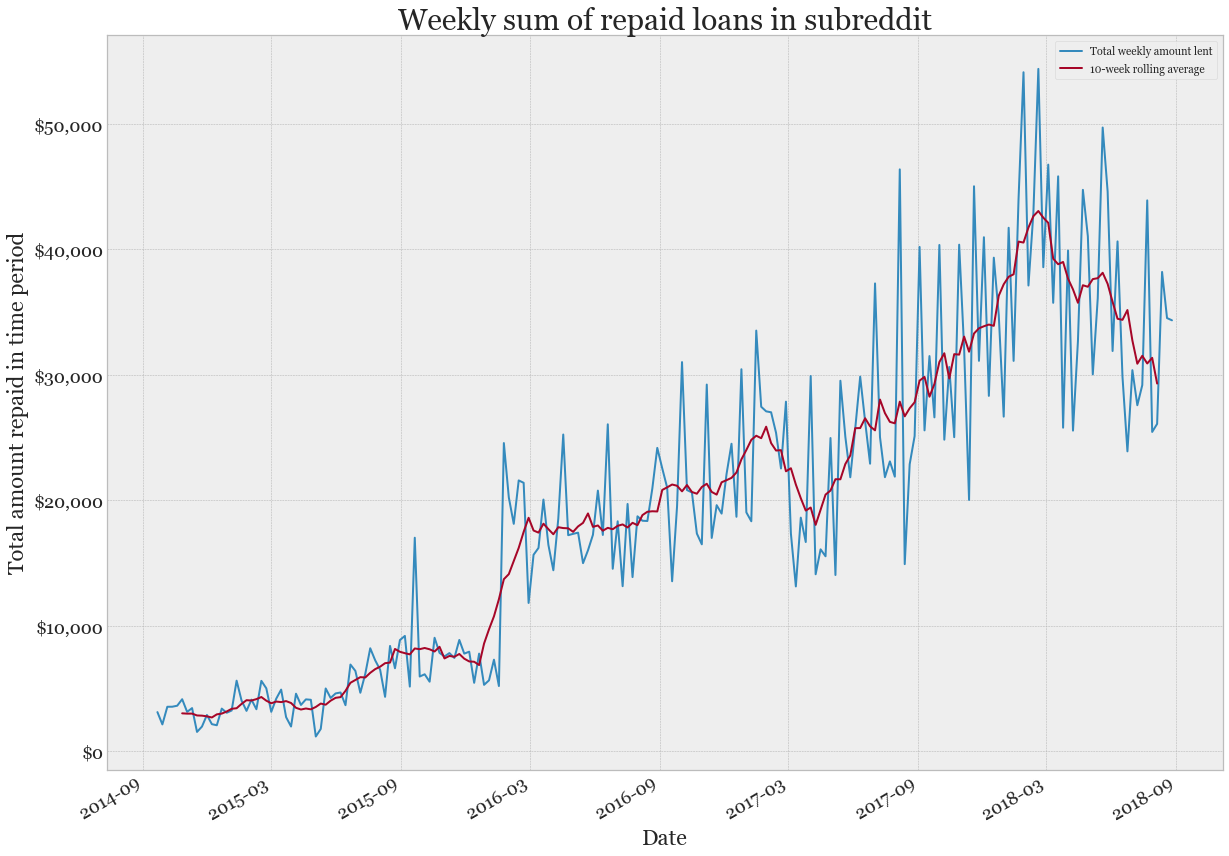

In [9]:
# Plot
fig, ax = plt.subplots()
ax.plot(df_m[df_m.index < pd.to_datetime('2018-09')])
ax.plot(df_m.index, rolling)
ax.set(xlabel="Date", ylabel="Total amount repaid in time period", 
        title="Weekly sum of repaid loans in subreddit")
ax.legend(["Total weekly amount lent", "10-week rolling average"])
ax.get_yaxis().set_major_formatter(
    ticker.FuncFormatter(lambda x, p: converter(x)))
fig.autofmt_xdate(bottom=0.2, rotation=30, ha='right')
#fig.savefig('weeklyloans.png', transparent=False, dpi=80, bbox_inches="tight")

It looks like the subreddit has been growing fairly steadily since it's inception, with two exceptions: a large spike in early 2016 (which represented a rise to a new level), and a falloff over the last 6 months. I'm still investigating the 2016 rise to a new level. The recent falloff may be due to an increase in spammers requesting loans, making lenders behave more conservatively (to be clear, that's just speculation on my part).

In [10]:
# Making a new aggregated dataframe: sum of loans repaid each year
df_y = df[df.paid == 1].copy()
del df_y['bor']
del df_y['lend']
del df_y['paid']
df_y = df_y.resample('Y').sum()
df_y['yr'] = ['2014','2015','2016','2017','2018']

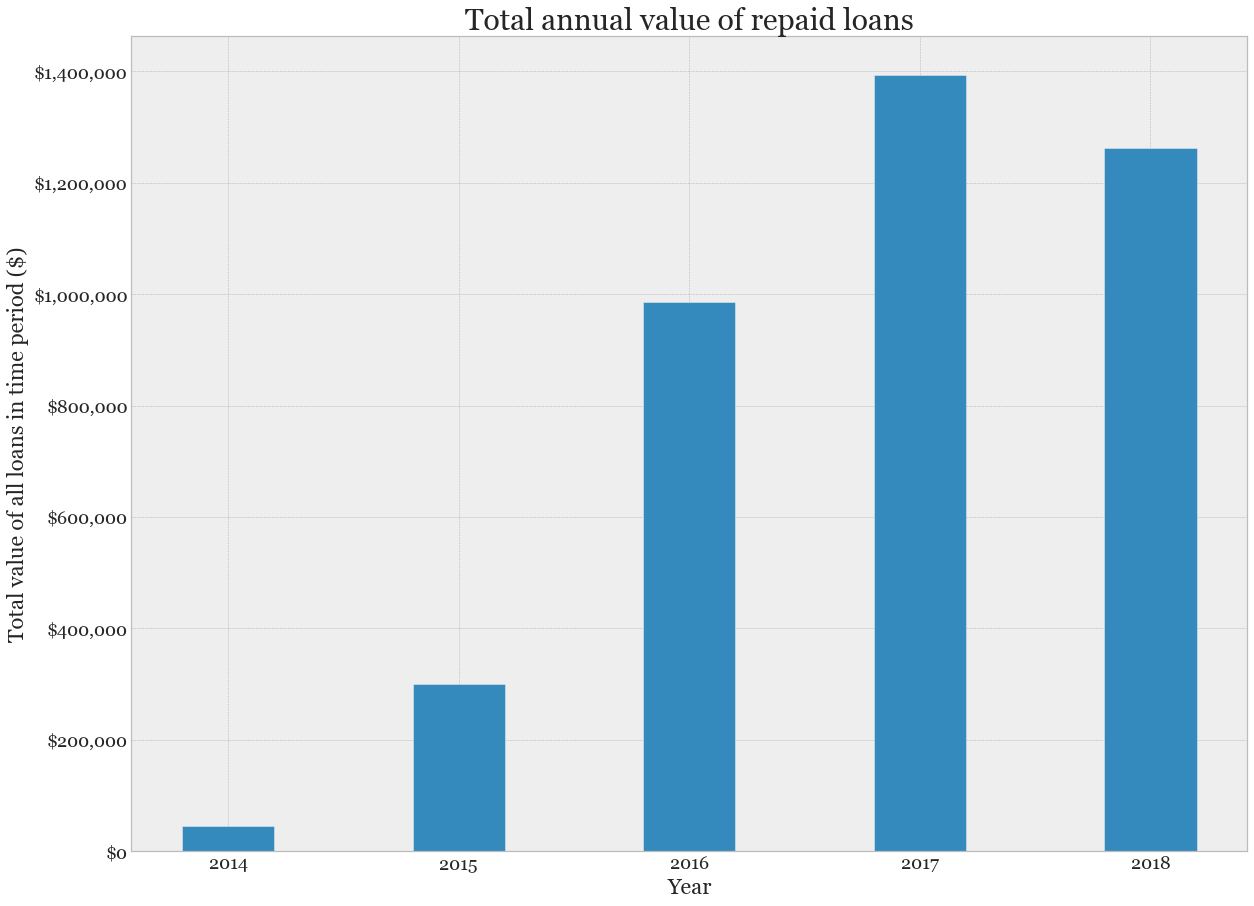

In [11]:
# Plot
fig, ax = plt.subplots()
ax.bar(df_y['yr'], df_y['amt'], width=0.4)
ax.set(xlabel="Year", ylabel="Total value of all loans in time period ($)",
       title="Total annual value of repaid loans")
ax.get_yaxis().set_major_formatter(
    ticker.FuncFormatter(lambda x, p: converter(x)))

## What day of the week are loans paid back on?

In [12]:
# Making an aggregated dataframe
df_dw = df[df.paid == 1].copy()
del df_dw['bor']
del df_dw['lend']
del df_dw['paid']
df_dw = df_dw.groupby([df_dw.index.year, df_dw.index.dayofweek]).count()
df_dw = df_dw.unstack(level=0)
df_dw.index = ['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun']

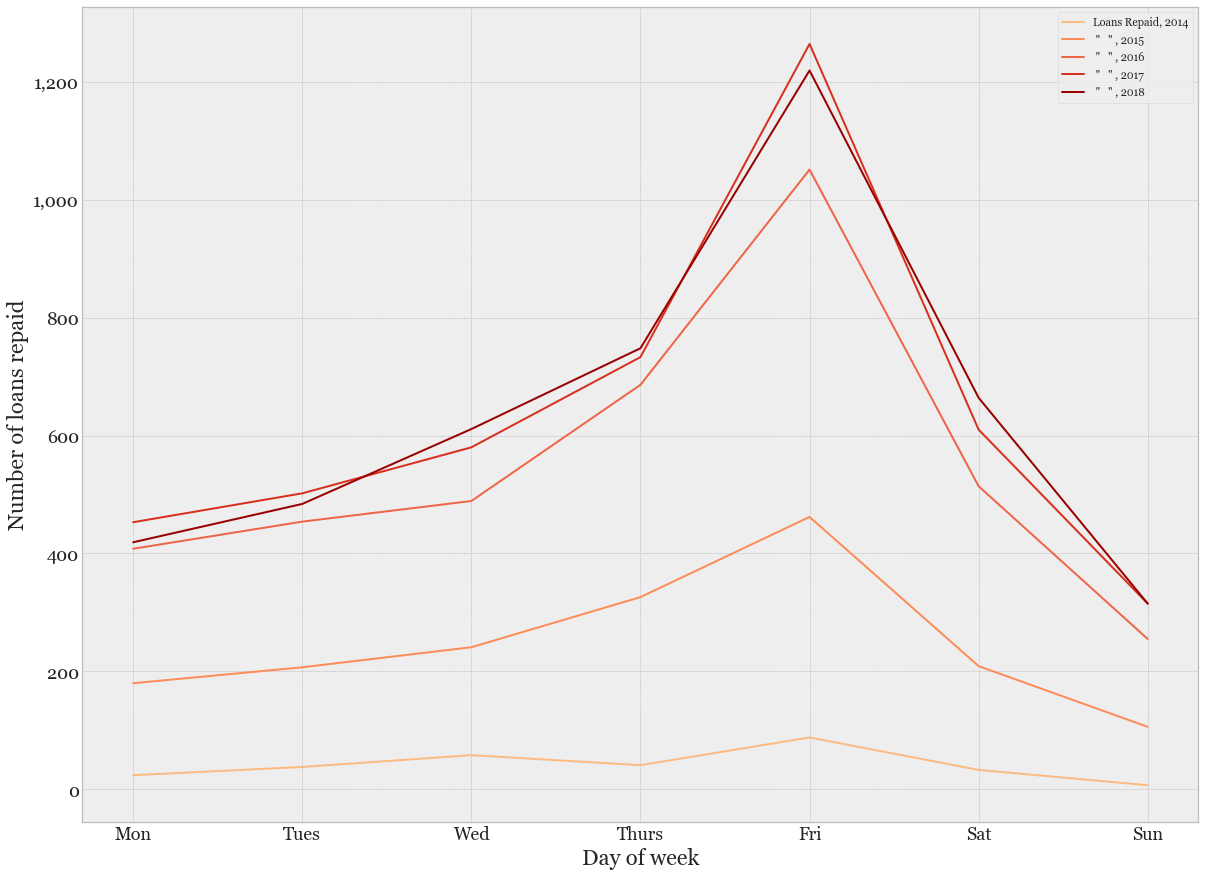

In [13]:
# Plot
# Make some sequential colors to use
colors = [ cm.inferno(x) for x in np.linspace(0, 1, 7) ]
xl = ['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun']
# Actual plotting

# fig, ax = plt.subplots()
# ax.bar(df_y['yr'], df_y['amt'])
# plt.xlabel("Year")
# plt.ylabel("Total value of all loans in time period ($)")
# plt.title("Total annual value of repaid loans")
# ax.get_yaxis().set_major_formatter(
#     matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

#from cycler import cycler

fig, ax = plt.subplots()
ax.set_prop_cycle(cycler('color', ['#fdbb84','#fc8d59','#ef6548','#d7301f','#990000']))
ax.plot(df_dw.index, df_dw['amt'])
ax.set(xlabel="Day of week", ylabel="Number of loans repaid")
plt.xticks([0.,  1.,  2.,  3.,  4.,  5.,  6.], xl)
plt.legend(["Loans Repaid, 2014", " \"   \" , 2015", " \"   \" , 2016", " \"   \" , 2017", " \"   \" , 2018"])
ax.get_yaxis().set_major_formatter(
    ticker.FuncFormatter(lambda x, p: format(int(x), ',')))


## How big are these loans?

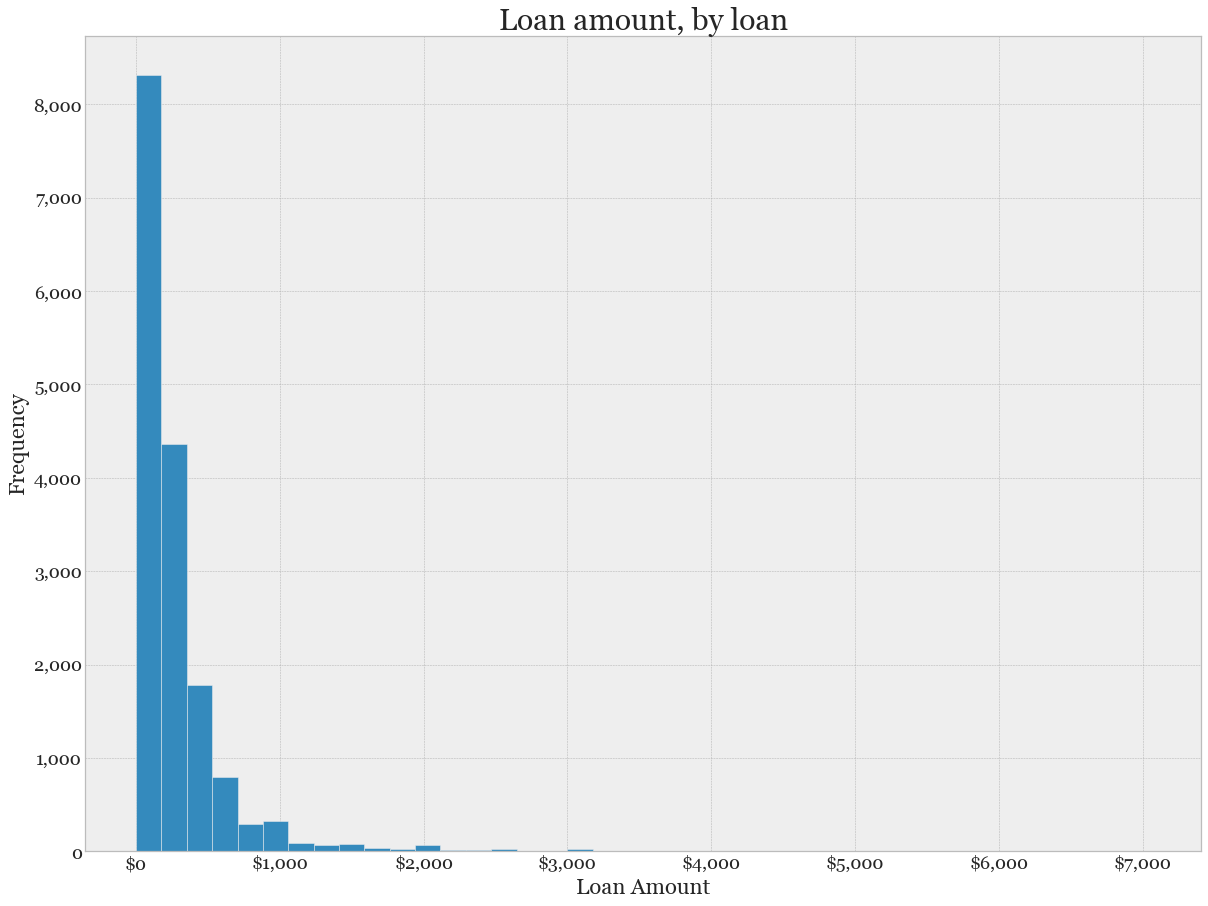

In [14]:
# Plotting by loan size
fig, ax = plt.subplots()
ax.hist(df['amt'], bins = 40)
ax.set(xlabel="Loan Amount", ylabel="Frequency", title="Loan amount, by loan")
ax.get_yaxis().set_major_formatter(
    ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax.get_xaxis().set_major_formatter(
    ticker.FuncFormatter(lambda x, p: converter(x)))

The distribution is right-skewed, which makes sense. What does the main cluster look like, for loans under a thousand dollars?

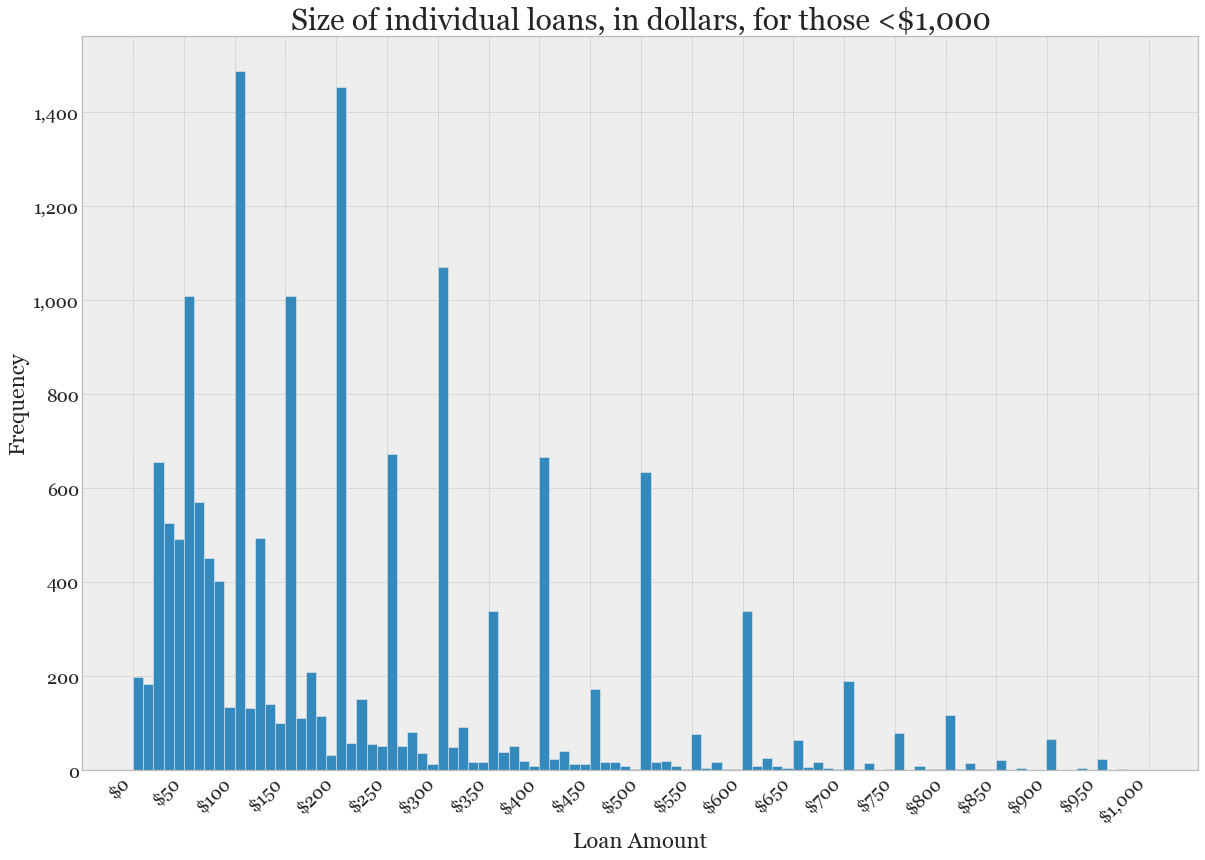

In [15]:
# Plotting by loan size for loans <$1000
amt = df['amt']
fig, ax = plt.subplots()
ax.hist(amt[amt < 1000], bins = 100)
ax.set_xticks(range(0,1050,50))
ax.set(xlabel="Loan Amount", ylabel="Frequency", title="Size of individual loans, in dollars, for those <$1,000")
ax.get_yaxis().set_major_formatter(
    ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax.get_xaxis().set_major_formatter(
    ticker.FuncFormatter(lambda x, p: converter(x)))
fig.autofmt_xdate(bottom=0.2, rotation=45, ha='right')

Looks like there's a big cluster between \\$25 and \\$100. It's also clear that people ask for loans that are nice, round numbers (e.g. multiples of 5 and 10), which is what creates that spiky-looking histogram.

Let's look at large loans (over $1000).

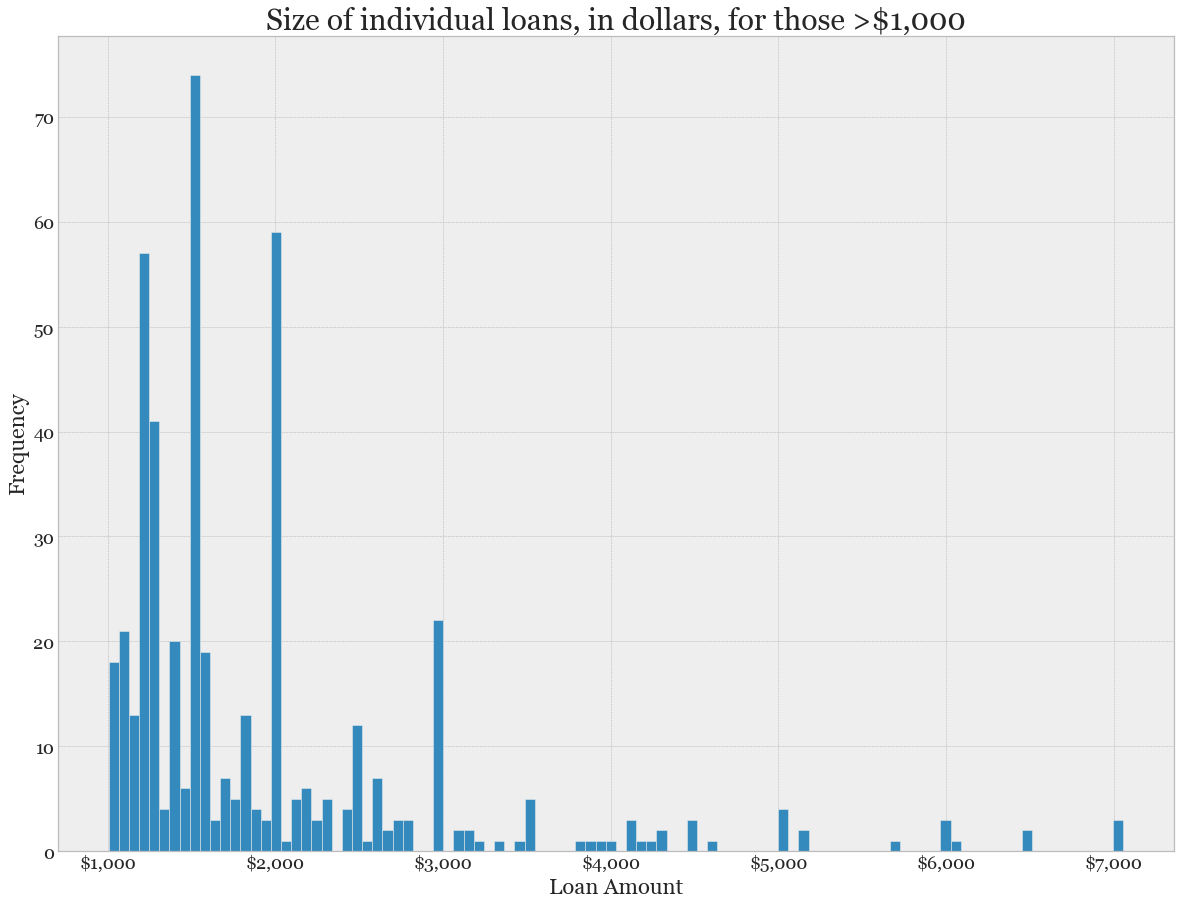

In [16]:
# Plotting by loan size for loans >$1000
amt = df['amt']
fig, ax = plt.subplots()
ax.hist(amt[amt > 1000], bins = 100)
#ax.set_xticks(range(0, 3200,50))
ax.set(xlabel="Loan Amount", ylabel="Frequency", title="Size of individual loans, in dollars, for those >$1,000")
ax.get_yaxis().set_major_formatter(
    ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax.get_xaxis().set_major_formatter(
    ticker.FuncFormatter(lambda x, p: converter(x)))

## What proportion of loans get repaid?

In [17]:
# Computing some stats
df_totalratio = df.groupby('paid').sum()
df_totalratio = df_totalratio.unstack(level=0)

df_totalratio_c = df.groupby('paid').count()
df_totalratio_c = df_totalratio_c.unstack(level=0)

In [18]:
# Printing the proportion of repaid loans / repaid dollars of principal
totlsum = 100 * (df_totalratio[1] / (df_totalratio[0] + df_totalratio[1]))
totlcount = 100 * (df_totalratio_c['amt'][1] / (df_totalratio_c['amt'][0] + df_totalratio_c['amt'][1]))

print("Percent of loans repaid: " + str(totlcount))
print("Percent of dollars loaned repaid: " + str(totlsum))

Percent of loans repaid: 90.56072477962782
Percent of dollars loaned repaid: 87.95836520983529


So, of every dollar of principal lent over the lifetime of the subreddit, 88 cents of it was repaid.

From the perspective of loan default rates, 90.5% of loans given were successfully repaid. 

This does not change meaningfully when we exclude earlier years (e.g. if we only consider 2017 and 2018), which tells us that this proportion has remained relatively constant over time.

Let's graph this ratio over time.

In [19]:
# Making an aggregated dataframe
df_y = df.copy()
del df_y['bor']
del df_y['lend']
df_y = df_y.groupby([df_y.index.year, 'paid']).sum()
df_y = df_y.unstack(level=1)
df_y = df_y.amt
df_y['unpaid'] = df_y[0]
df_y['paid'] = df_y[1]
del df_y[0]
del df_y[1]

paid,unpaid,paid
date,,
2014,9952.20,45568.530
2015,38579.51,299636.160
2016,106578.51,985404.530
2017,165457.51,1393763.185
2018,225145.25,1261799.110


In [20]:
# Calculating ratio over time
df_y_prop = df_y.copy()
df_y_prop['ratio'] = df_y['unpaid'] / df_y['paid']
df_y_prop['success_prop'] = df_y['paid'] / (df_y['unpaid'] + df_y['paid'])
del df_y_prop['unpaid']
del df_y_prop['paid']
del df_y_prop['ratio']

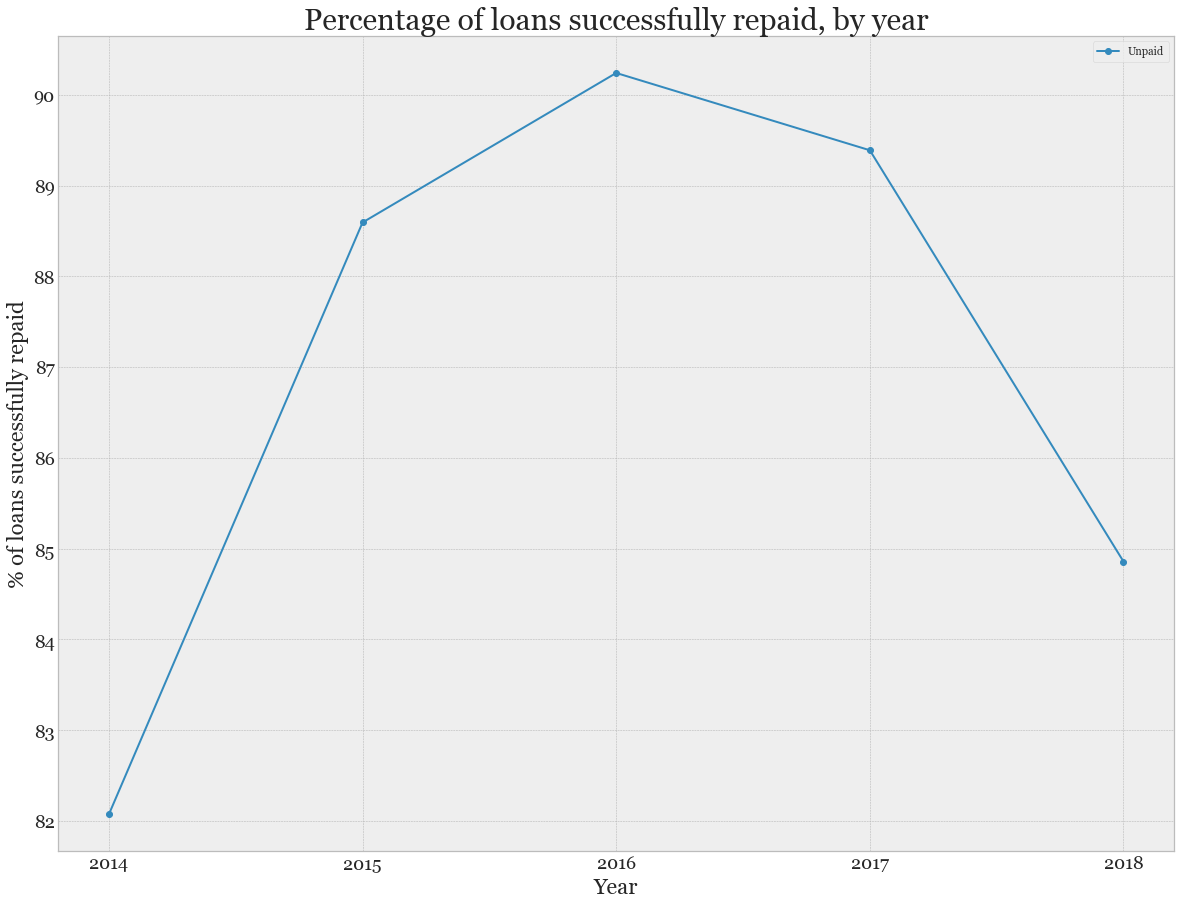

In [21]:
# Plot
fig, ax = plt.subplots()
ax.plot(df_y_prop, marker='o')
ax.set(xlabel="Year", ylabel="% of loans successfully repaid", title="Percentage of loans successfully repaid, by year")
ax.xaxis.set_ticks(np.arange(2014, 2019, 1))
ax.get_yaxis().set_major_formatter(
    ticker.FuncFormatter(lambda x, p: '%d'%(100 * x)))
ax.legend(['Unpaid', 'Paid'])

Another way to visualize some related metrics is to look at the number of repaid and unpaid loans over time. I like this visualization because we can see the component parts of the ratio we plotted above. (e.g. The ratio dropped in 2018— how much of that change is due to a rise in defaulted loans vs. a drop in repaid loans?)

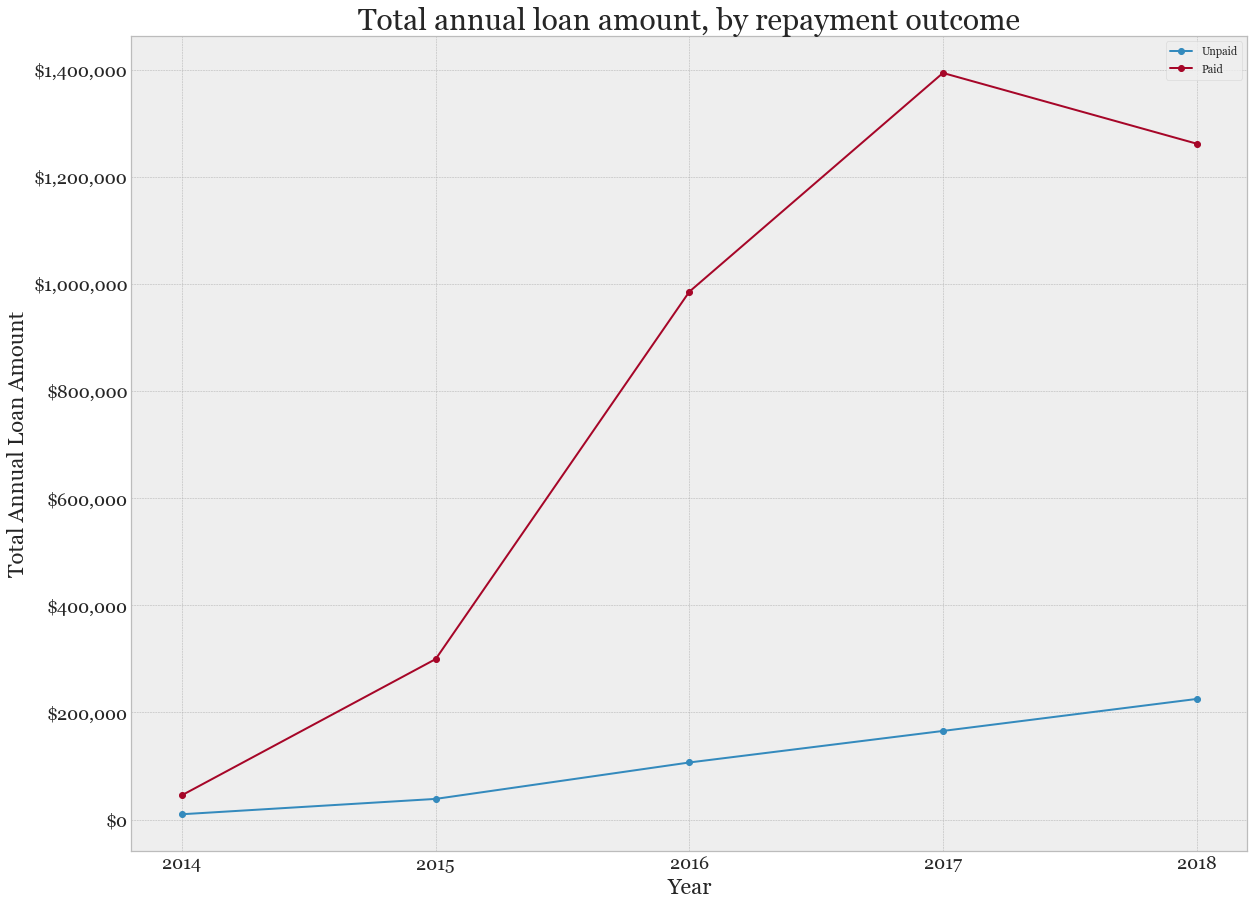

In [22]:
# Plot
fig, ax = plt.subplots()
ax.plot(df_y, marker='o')
ax.set(xlabel="Year", ylabel="Total Annual Loan Amount", title="Total annual loan amount, by repayment outcome")
ax.xaxis.set_ticks(np.arange(2014, 2019, 1))
ax.get_yaxis().set_major_formatter(
    ticker.FuncFormatter(lambda x, p: converter(x)))
ax.legend(['Unpaid', 'Paid'])

## Let's take a look at lender behavior

In [23]:
# Extracting information about lenders
df_lendgroup = df.groupby('lend')

lsum = df_lendgroup.aggregate(np.sum)['amt']
lcount = df_lendgroup.agg(pd.Series.nunique)['amt']

Text(0.5,1,'Number of lifetime loans, by lender')

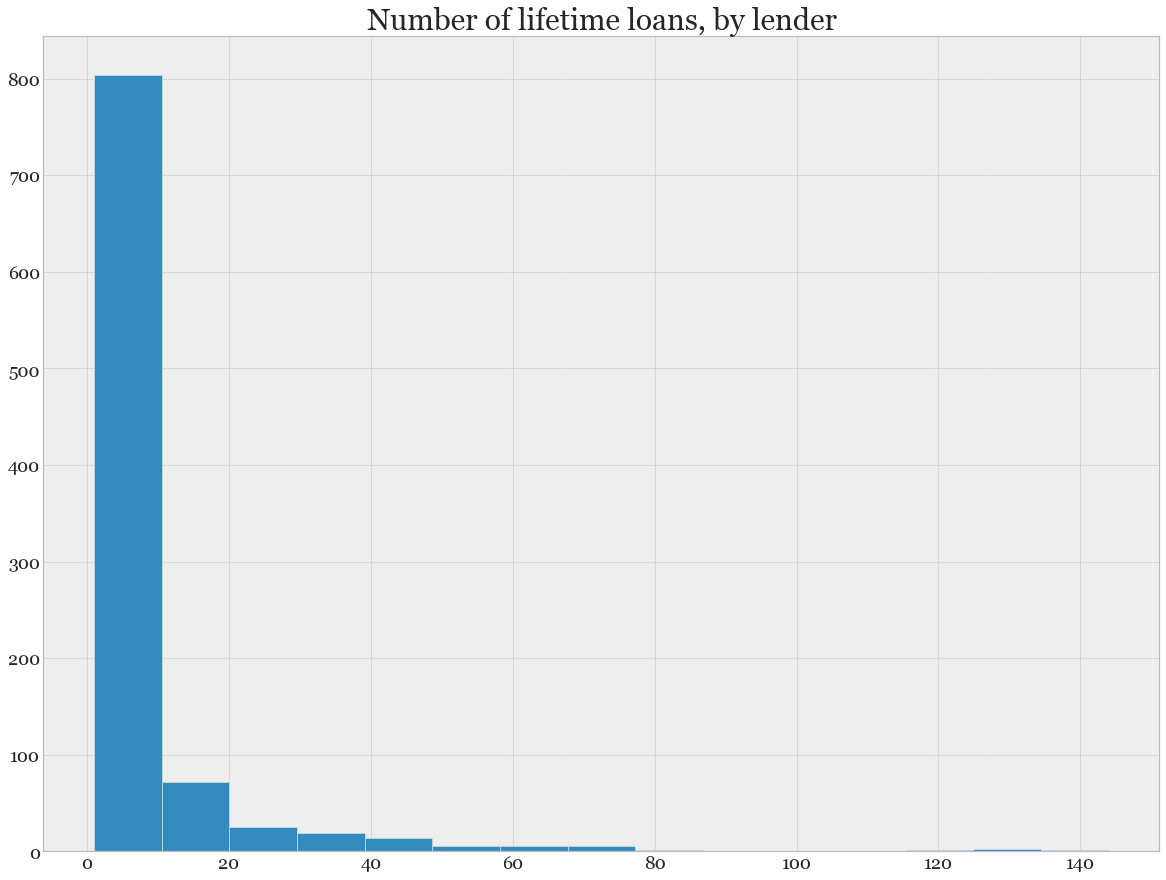

In [24]:
# Plot number of loans by lender
plt.hist(lcount, bins = 15)
plt.title("Number of lifetime loans, by lender", size = 30)

The vast majority of lenders give less than 10 loans in their lifetime, and there's a long tail with a max around 130 loans.

Text(0.5,1,'Sum of lifetime loans, per lender, for those <$1000')

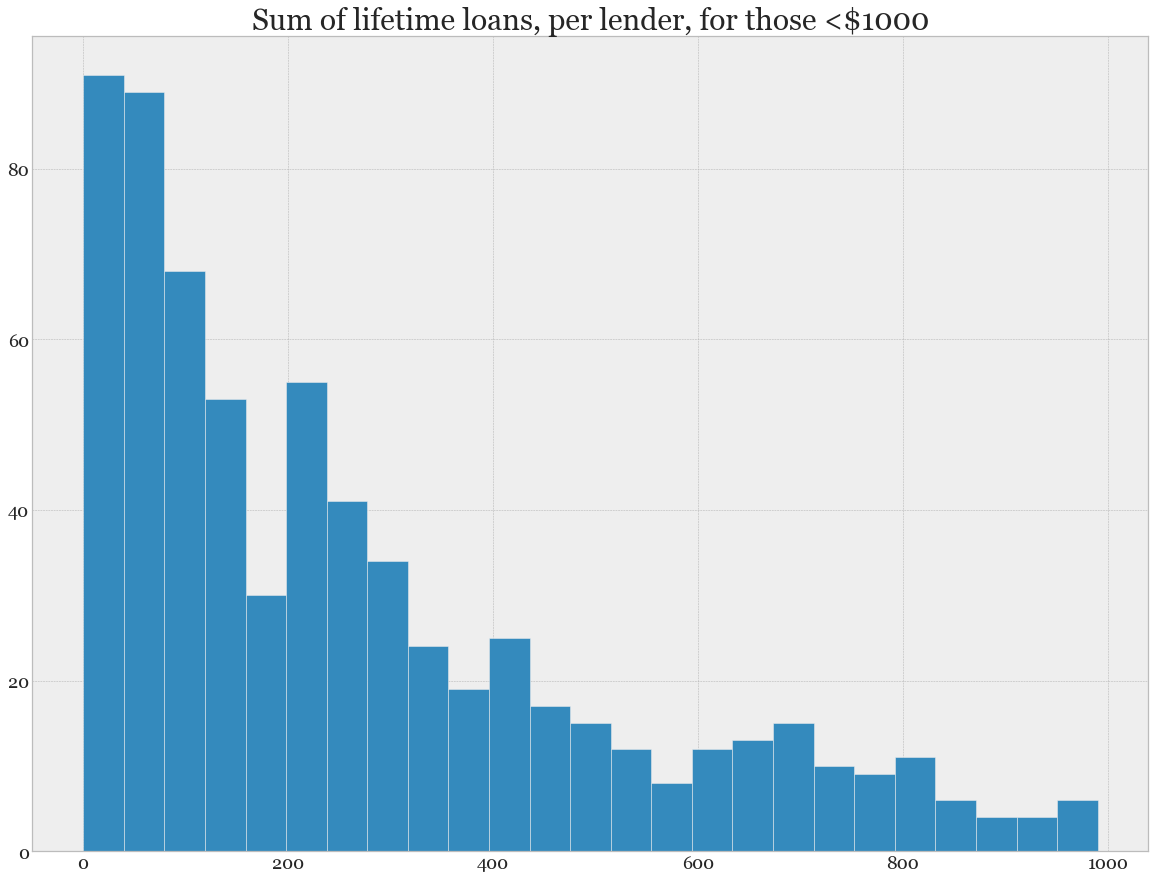

In [29]:
# Plot total principal loaned by lender for those less than $1000
plt.hist(lsum[(lsum < 1000)], bins = 25)
plt.title("Sum of lifetime loans, per lender, for those <$1000", size = 30)

In [26]:
lsum[lsum > 50000].describe()

count        20.000000
mean     125023.980250
std       84916.723796
min       50246.000000
25%       64272.820000
50%       94063.260000
75%      147445.757500
max      354795.600000
Name: amt, dtype: float64

In [27]:
lsum[lsum > 100000].describe()

count        10.000000
mean     185969.629500
std       82524.607336
min      103890.420000
25%      123903.897500
50%      153427.515000
75%      231675.483750
max      354795.600000
Name: amt, dtype: float64

There are 20 lenders who have lent over \\$50,000 each, and 10 lenders who have lent over \\$100,000 each. Keep in mind that these numbers are probably low, because it is common practice for lenders to give pre-arranged loans to borrowers they've worked with before without posting in the forum at all. The largest lender has lent more than \\$350,000 in principal over their /r/borrow lifetime.

The lenders who have lent over $100,000 in total are listed below.

In [28]:
lfindbig = df_lendgroup[['lend','amt']].aggregate(np.sum)
lfindbig[lfindbig['amt'] > 100000].sort_values(['amt'])

,amt
lend,
MrMacgoot,103890.420
geroll,111893.490
jsquash87,121582.870
saintsintosea,130866.980
kashifr,141464.000
FoxK56,165391.030
_cup_,225846.105
l80sman104,233618.610
IgrewAtomato,270347.190


## Conclusion

The next step here is to try to predict likelihood of default based on a user's history. I'll likely start working on that project in November 2018! Until then, I'll be focusing on other things. 

I'm always interested in hearing responses, feedback, criticism, or, well, anything! You can get in touch with me via my website contact page: [quinnbatten.com/contact](https://www.quinnbatten.com/contact/)